In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from PIL import ImageEnhance
from skimage.io import imread
import matplotlib.pyplot as plt

import os, random, pathlib, warnings, itertools, math
warnings.filterwarnings("ignore")

import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.metrics import confusion_matrix

from tensorflow.keras import models
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3,preprocess_input
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dense, Dropout

K.clear_session()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Loading the dataset
Let's define the path to base directories used in the project

In [ ]:
dataset='/content/drive/MyDrive/Vegetable Images'

train_folder = os.path.join(dataset,"train")
test_folder = os.path.join(dataset,"validation")
validation_folder = os.path.join(dataset,"test")

#Counting number of images in a folder. (test set in our case)

In [ ]:
def count_files(rootdir):
    '''counts the number of files in each subfolder in a directory'''
    for path in pathlib.Path(rootdir).iterdir():
        if path.is_dir():
            print("There are " + str(len([name for name in os.listdir(path) \
            if os.path.isfile(os.path.join(path, name))])) + " files in " + \
            str(path.name))

count_files(os.path.join(test_folder))

There are 210 files in Papaya
There are 200 files in Potato
There are 200 files in Capsicum
There are 200 files in Cabbage
There are 200 files in Radish
There are 200 files in Cucumber
There are 200 files in Tomato
There are 210 files in Pumpkin
There are 200 files in Cauliflower
There are 210 files in Carrot
There are 200 files in Brinjal
There are 200 files in Bottle_Gourd
There are 200 files in Broccoli
There are 210 files in Bitter_Gourd
There are 200 files in Bean


As evident, Dataset is well balanced with each class containing :
1000 images for training set.
200 images for test set.

#2. Image Processing

#The goal of image processing is improvement of pictorial information for human interpretation. Basic manipulation and filtering can lead to increased understanding for feature extraction as well.

Here we can select any vegetable of our choice and a random image from the class is displayed with comparison to a processed image.

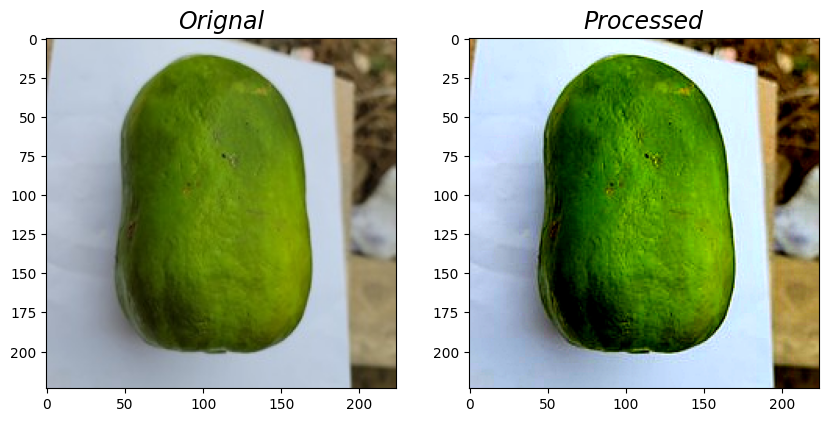

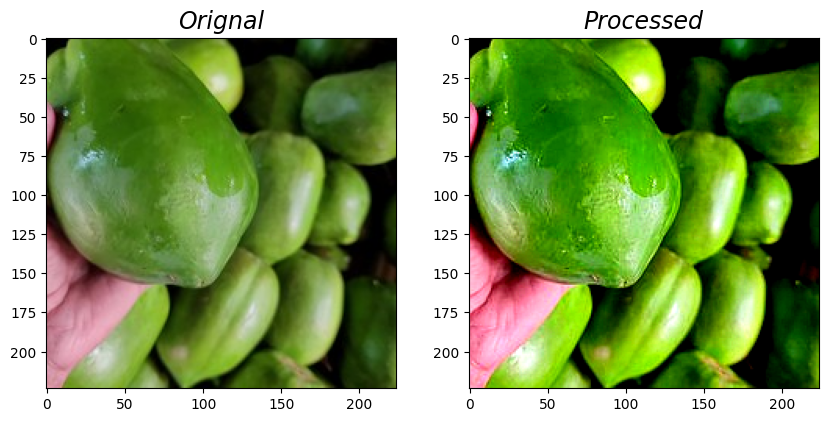

In [ ]:
image_folder="Papaya"  # The vegetable you want to display
number_of_images=2       # Number of images to display

def Preprocess():
    j=1
    for i in range(number_of_images):

        folder = os.path.join(test_folder,image_folder)
        a=random.choice(os.listdir(folder))

        image=Image.open(os.path.join(folder,a))
        image_duplicate=image.copy()
        plt.figure(figsize=(10,10))

        plt.subplot(number_of_images,2,j)
        plt.title(label='Orignal', size=17, pad='7.0', loc="center", fontstyle='italic')
        plt.imshow(image)
        j+=1

        image1=ImageEnhance.Color(image_duplicate).enhance(1.35)
        image1=ImageEnhance.Contrast(image1).enhance(1.45)
        image1=ImageEnhance.Sharpness(image1).enhance(2.5)

        plt.subplot(number_of_images,2,j)
        plt.title(label='Processed', size=17, pad='7.0', loc="center", fontstyle='italic')
        plt.imshow(image1)
        j+=1

Preprocess()

We increased the color saturation, contrast and finally sharpened the image for drawing texture and viewer focus. The image after processing looks appealing and brighter

#3. Data Visualization (EDA)


We can start exploring the dataset and visualize any class label (for instance, Capsicum). You can choose any vegetable to visualize the images of that class. Changing rows and columns variable also results in different format positioning of matplotlib.

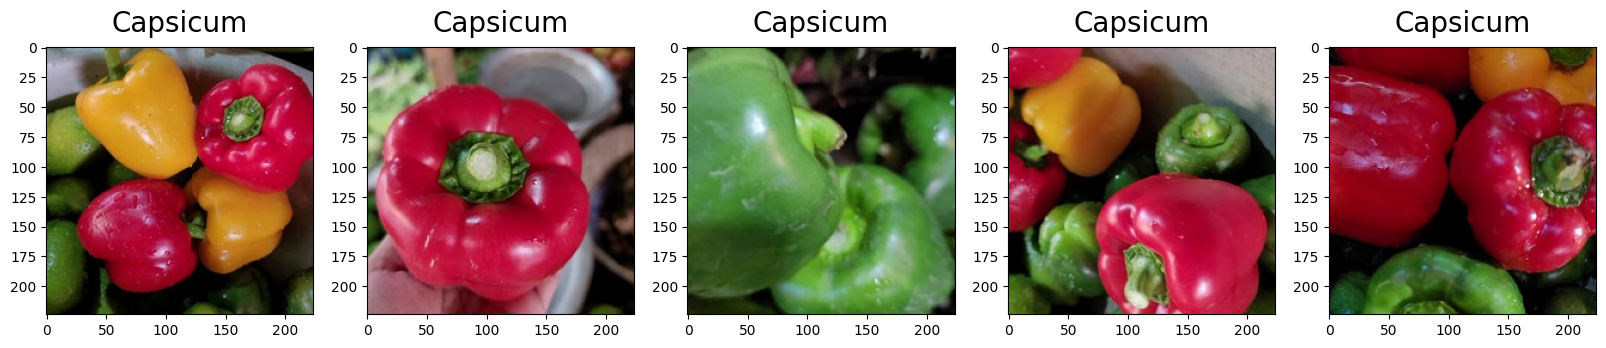

In [ ]:
select_vegetable="Capsicum"
rows,columns = 1,5

display_folder=os.path.join(train_folder,select_vegetable)
total_images=rows*columns
fig=plt.figure(1, figsize=(20, 10))

for i,j in enumerate(os.listdir(display_folder)):

    img = plt.imread(os.path.join(train_folder,select_vegetable,j))
    fig=plt.subplot(rows, columns, i+1)
    fig.set_title(select_vegetable, pad = 11, size=20)
    plt.imshow(img)

    if i==total_images-1:
        break

#Now let's visualize the whole dataset by picking a random image from each class inside training dataset.

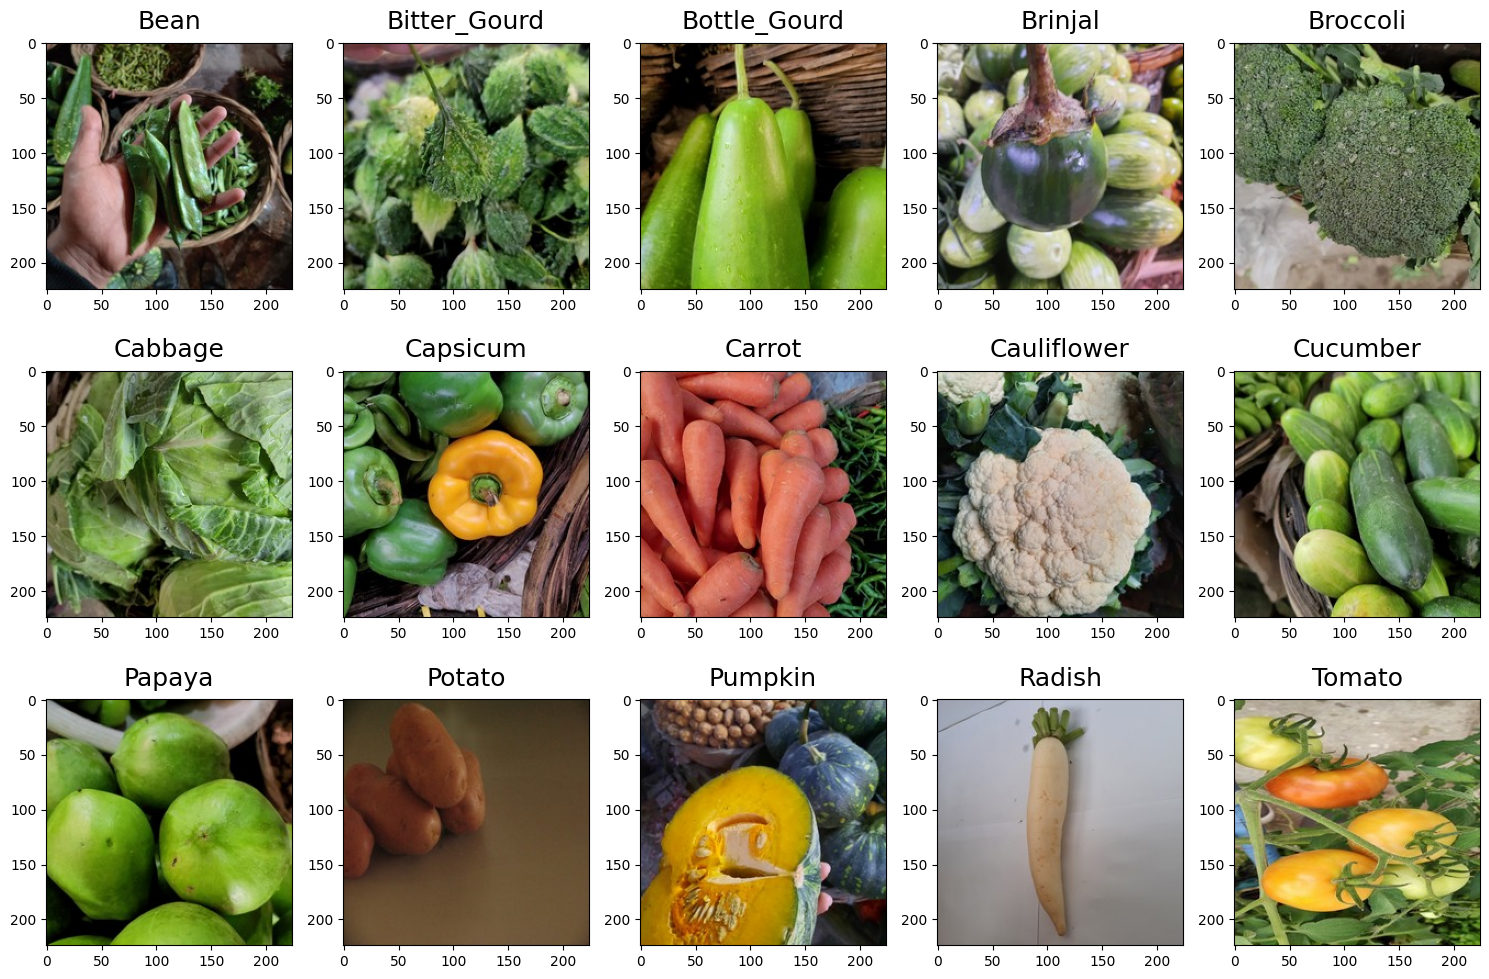

In [ ]:
images = []

for food_folder in sorted(os.listdir(train_folder)):
    food_items = os.listdir(train_folder + '/' + food_folder)
    food_selected = np.random.choice(food_items)
    images.append(os.path.join(train_folder,food_folder,food_selected))

fig=plt.figure(1, figsize=(15, 10))

for subplot,image_ in enumerate(images):
    category=image_.split('/')[-2]
    imgs = plt.imread(image_)
    a,b,c=imgs.shape
    fig=plt.subplot(3, 5, subplot+1)
    fig.set_title(category, pad = 10,size=18)
    plt.imshow(imgs)

plt.tight_layout()

#4. Model Building

Let's start building the transfer learning network to train our model using InceptionV3.

In [ ]:
IMAGE_SIZE = [224, 224]

inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in inception.layers:
    layer.trainable = False

x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

prediction = Dense(15, activation='softmax')(x)

model = Model(inputs=inception.input, outputs=prediction)

model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

87910968/87910968 [==============================] - 2s 0us/step


#5. Model Training


In [ ]:
train_datagen = image.ImageDataGenerator(rescale = 1./255,
                                         shear_range = 0.2,
                                         zoom_range = 0.2,
                                         horizontal_flip = True)

test_datagen = image.ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(
    train_folder,
    target_size = (224, 224),
    batch_size = 64,
    class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(
    test_folder,
    target_size = (224, 224),
    batch_size = 64,
    class_mode = 'categorical')

Found 15020 images belonging to 15 classes.
Found 3040 images belonging to 15 classes.


In [ ]:
class_map = training_set.class_indices
class_map

{'Bean': 0,
 'Bitter_Gourd': 1,
 'Bottle_Gourd': 2,
 'Brinjal': 3,
 'Broccoli': 4,
 'Cabbage': 5,
 'Capsicum': 6,
 'Carrot': 7,
 'Cauliflower': 8,
 'Cucumber': 9,
 'Papaya': 10,
 'Potato': 11,
 'Pumpkin': 12,
 'Radish': 13,
 'Tomato': 14}

In [ ]:
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=5,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/5
209/235 [=========================>....] - ETA: 7:22 - loss: 0.2836 - accuracy: 0.9140

#Saving the Model

In [ ]:
model.save('model_inceptionV3_epoch5.h5')

#Accuracy and Loss Curves

In [ ]:
def plot_accuracy(history):

    plt.plot(history.history['accuracy'],label='train accuracy')
    plt.plot(history.history['val_accuracy'],label='validation accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig('Accuracy_v1_InceptionV3')
    plt.show()

def plot_loss(history):

    plt.plot(history.history['loss'],label="train loss")
    plt.plot(history.history['val_loss'],label="validation loss")
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig('Loss_v1_InceptionV3')
    plt.show()

plot_accuracy(r)
plot_loss(r)

NameError: ignored

#Model Layers

In [ ]:
print("Total layers in the model : ",len(model.layers),"\n")

layers = [layer.output for layer in model.layers[0:]]
layer_names = []
for layer in model.layers[0:]:
    layer_names.append(layer.name)

print("First layer : ", layer_names[0])
print("InceptionV3 layers : Layer 2 to Layer 311")
print("Our fine tuned layers : ", layer_names[311:314])
print("Final Layer : ", layer_names[314])

#6. Predictions

Loading the model

In [ ]:
K.clear_session()
path_to_model='./model_inceptionV3_epoch5.h5'
print("Loading the model..")
model = load_model(path_to_model)
print("Done!")

#Testing the model on validation set

In [ ]:
validation_data_dir = '../input/vegetable-image-dataset/Vegetable Images/test'

validation_datagen = image.ImageDataGenerator(rescale=1. / 255)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(224,224),
    batch_size=64,
    class_mode='categorical')

scores = model.evaluate_generator(validation_generator)
print("Test Accuracy: {:.3f}".format(scores[1]))

#Functions to predict the output of our model

In [ ]:
category={
    0: 'Bean', 1: 'Bitter_Gourd', 2: 'Bottle_Gourd', 3 : 'Brinjal', 4: "Broccoli", 5: 'Cabbage', 6: 'Capsicum', 7: 'Carrot', 8: 'Cauliflower',
    9: 'Cucumber', 10: 'Papaya', 11: 'Potato', 12: 'Pumpkin', 13 : "Radish", 14: "Tomato"
}

def predict_image(filename,model):
    img_ = image.load_img(filename, target_size=(224, 224))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0)
    img_processed /= 255.

    prediction = model.predict(img_processed)
    index = np.argmax(prediction)

    plt.title("Prediction - {}".format(category[index]))
    plt.imshow(img_array)

def predict_dir(filedir,model):
    cols=3
    pos=0
    images=[]
    total_images=len(os.listdir(filedir))
    rows=total_images//cols + 1

    true=filedir.split('/')[-1]

    for i in sorted(os.listdir(filedir)):
        images.append(os.path.join(filedir,i))

    for subplot, imggg in enumerate(images):
        img_ = image.load_img(imggg, target_size=(224, 224))
        img_array = image.img_to_array(img_)
        img_processed = np.expand_dims(img_array, axis=0)
        img_processed /= 255.
        prediction = model.predict(img_processed)
        index = np.argmax(prediction)

        pred=category.get(index)
        if pred==true:
            pos+=1

    acc=pos/total_images
    print("Accuracy for {orignal}: {:.2f} ({pos}/{total})".format(acc,pos=pos,total=total_images,orignal=true))

#Single image prediction

In [ ]:
predict_image(os.path.join(validation_folder,'Cauliflower/1064.jpg'),model)

#Validation directory accuracy prediction

In [ ]:
for i in os.listdir(validation_folder):
    predict_dir(os.path.join(validation_folder,i),model)

#7. Evaluation

Loading the model

Confusion Matrix for evaluating the performance of our classification model.

In [ ]:
def labels_confusion_matrix(validation_folder):

    folder_path=validation_folder

    mapping={}
    for i,j in enumerate(sorted(os.listdir(folder_path))):
        mapping[j]=i

    files=[]
    real=[]
    predicted=[]

    for i in os.listdir(folder_path):

        true=os.path.join(folder_path,i)
        true=true.split('/')[-1]
        true=mapping[true]

        for j in os.listdir(os.path.join(folder_path,i)):

            img_ = image.load_img(os.path.join(folder_path,i,j), target_size=(224,224))
            img_array = image.img_to_array(img_)
            img_processed = np.expand_dims(img_array, axis=0)
            img_processed /= 255.
            prediction = model.predict(img_processed)
            index = np.argmax(prediction)

            predicted.append(index)
            real.append(true)

    return (real,predicted)

def print_confusion_matrix(real,predicted):
    total_output_labels = 15
    cmap="turbo"
    cm_plot_labels = [i for i in range(15)]

    cm = confusion_matrix(y_true=real, y_pred=predicted)
    df_cm = pd.DataFrame(cm,cm_plot_labels,cm_plot_labels)
    sns.set(font_scale=1.2) # for label size
    plt.figure(figsize = (15,10))
    s=sns.heatmap(df_cm,fmt="d", annot=True,cmap=cmap) # font size

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix.png')
    plt.show()

In [ ]:
y_true,y_pred=labels_confusion_matrix(validation_folder)
print_confusion_matrix(y_true,y_pred)

#Visualizing all incorrect images predicted for a particular vegetable category by our classifier.

In [ ]:
def wrong_input_capture(test_category):

    a=os.path.basename(test_category)
    wrong_array=[]

    for i in os.listdir(test_category):

        imggg=os.path.join(test_category,i)

        img_ = image.load_img(imggg, target_size=(224, 224))
        img_array = image.img_to_array(img_)
        img_processed = np.expand_dims(img_array, axis=0)
        img_processed /= 255.
        prediction = model.predict(img_processed)

        index = np.argmax(prediction)
        pred=category.get(index)

        if not pred==a:
            wrong_array.append((imggg,pred))

    return wrong_array

def visualize_wrong_input(images):

    fig=plt.figure(1, figsize=(20, 25))
    total_images=len(images)
    rows=math.ceil(float(total_images/3))
    for subplot,(image_path,predicted) in enumerate(images):
        img = plt.imread(image_path)
        fig=plt.subplot(rows, 3, subplot+1)
        fig.set_title("Predicted - {}".format(predicted), pad = 10,size=18)
        plt.imshow(img)

    plt.tight_layout()

In [ ]:
vegetable="Broccoli"
path=os.path.join(validation_folder,vegetable)
images= wrong_input_capture(path)
visualize_wrong_input(images)